In [1]:
# !pip install -U scikit-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import math
import time
from pathlib import Path
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models.video import r3d_18  # 3D ResNet-18
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [3]:
def fix_path(p):
    p = str(p).replace("\\", "/")
    if "preprocessed_fleischner_fixed/" in p:
        p = p.split("preprocessed_fleischner_fixed/")[1]
    return f"../dataset/{p}"

In [14]:
# -------------------------
# CONFIG
# -------------------------
DATA_CSV = "../metadata/augmented_classification_metadata.csv"        # your combined metadata (3600 rows)
IMAGE_KEY = "image"                    # column name with image path
LABEL_KEY = "label_3class"             # column name with numeric labels (0/1/2)
MASK_KEY = "mask"                      # optional mask path column
UID_KEY = "uid"

OUT_DIR = "../models/3d_resnet"
os.makedirs(OUT_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

In [15]:
# Model / training hyperparams
NUM_CLASSES = 3
BATCH_SIZE = 8              # reduce if GPU memory is limited
NUM_EPOCHS = 60
LR = 1e-4
WEIGHT_DECAY = 1e-5
NUM_WORKERS = 6
INPUT_SHAPE = (64, 64, 64)  # target patch shape (D,H,W) for the network
CROP_WITH_MASK = True       # If True, crop around mask bounding box then resize; else center-crop
USE_AMP = True              # mixed precision

# Augmentation params (applied on-the-fly in dataset)
AUG_PROB = 0.5
GAUSSIAN_NOISE_STD = 0.01


# Training utilities
BEST_MODEL_PATH = os.path.join(OUT_DIR, "best_model.pth")
LAST_MODEL_PATH = os.path.join(OUT_DIR, "last_model.pth")
LOG_CSV = os.path.join(OUT_DIR, "training_log.csv")


def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

In [16]:
# -------------------------
# HELPERS: load and preprocess
# -------------------------
def load_nii(path: str) -> np.ndarray:
    """Load nii.gz and return numpy array (Z,Y,X) or (D,H,W) as float32."""
    img = nib.load(path)
    arr = img.get_fdata(dtype=np.float32)
    # ensure shape ordering is (D,H,W) consistent with our use (z,y,x)
    # nibabel returns (X, Y, Z) depending — but in our pipeline arr.shape should be (H,W,D) often.
    # We will not transpose blindly; we assume your earlier pipeline ensured consistent orientation and shape.
    # If needed, adjust here.
    if arr.ndim == 4:
        arr = arr[..., 0]
    return arr.astype(np.float32)

def hu_windowing(img: np.ndarray, window_center: int = -600, window_width: int = 1500) -> np.ndarray:
    """Apply HU windowing typical for lung/CT. Adjust center/width if desired."""
    lower = window_center - window_width/2
    upper = window_center + window_width/2
    img = np.clip(img, lower, upper)
    img = (img - lower) / (upper - lower)  # normalize to 0..1
    return img

def resize_vol(vol: np.ndarray, target_shape: Tuple[int,int,int]) -> np.ndarray:
    """Resize using simple np interpolation via scipy if available, fallback to basic cropping/pad."""
    import scipy.ndimage as ndi
    factors = [t / s for s, t in zip(vol.shape, target_shape)]
    vol_resized = ndi.zoom(vol, zoom=factors, order=1)  # linear interpolation
    return vol_resized

def center_crop_or_pad(vol: np.ndarray, target_shape: Tuple[int,int,int]) -> np.ndarray:
    """Center-crop or pad to target_shape (D,H,W)."""
    out = np.zeros(target_shape, dtype=vol.dtype)
    dz, dh, dw = vol.shape
    td, th, tw = target_shape
    # compute start indices
    sd = max(0, (dz - td)//2)
    sh = max(0, (dh - th)//2)
    sw = max(0, (dw - tw)//2)
    ed = sd + min(td, dz)
    eh = sh + min(th, dh)
    ew = sw + min(tw, dw)
    out_sd = max(0, (td - dz)//2)
    out_sh = max(0, (th - dh)//2)
    out_sw = max(0, (tw - dw)//2)
    out[out_sd:out_sd+(ed-sd), out_sh:out_sh+(eh-sh), out_sw:out_sw+(ew-sw)] = vol[sd:ed, sh:eh, sw:ew]
    return out

def crop_around_mask(image: np.ndarray, mask: np.ndarray, margin: int = 6, target_shape: Tuple[int,int,int]=(64,64,64)) -> np.ndarray:
    """Crop tight bounding box around mask then center-pad/crop to target shape."""
    coords = np.argwhere(mask > 0)
    if coords.size == 0:
        # fallback to center crop
        return center_crop_or_pad(image, target_shape)
    zmin, ymin, xmin = coords.min(axis=0)
    zmax, ymax, xmax = coords.max(axis=0)
    zmin = max(0, zmin - margin); ymin = max(0, ymin - margin); xmin = max(0, xmin - margin)
    zmax = min(image.shape[0]-1, zmax + margin); ymax = min(image.shape[1]-1, ymax + margin); xmax = min(image.shape[2]-1, xmax + margin)
    cropped = image[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
    # resize or pad to target
    if cropped.shape != target_shape:
        cropped = resize_vol(cropped, target_shape)
    return cropped

In [17]:
# -------------------------
# DATASET
# -------------------------
class NiiDataset(Dataset):
    def __init__(self, df: pd.DataFrame, image_col: str = IMAGE_KEY, label_col: str = LABEL_KEY,
                 mask_col: Optional[str] = MASK_KEY, input_shape: Tuple[int,int,int]=INPUT_SHAPE,
                 augment: bool=True):
        self.df = df.reset_index(drop=True)
        self.image_col = image_col
        self.label_col = label_col
        self.mask_col = mask_col if mask_col in df.columns else None
        self.input_shape = input_shape
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def random_flip(self, vol: np.ndarray) -> np.ndarray:
        if random.random() < 0.5:
            # random axis flip
            axes = []
            if random.random() < 0.5: axes.append(0)
            if random.random() < 0.5: axes.append(1)
            if random.random() < 0.5: axes.append(2)
            for a in axes:
                vol = np.flip(vol, axis=a).copy()
        return vol

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row[self.image_col]
        label = int(row[self.label_col])

        img = load_nii(img_path)   # numpy (D,H,W)

        # apply HU windowing and normalization
        img = hu_windowing(img)    # values 0..1

        # optional mask-based crop for ROI
        if self.mask_col and pd.notna(row.get(self.mask_col, None)) and CROP_WITH_MASK:
            mask_path = row[self.mask_col]
            try:
                mask = load_nii(mask_path)
            except Exception:
                mask = np.zeros_like(img)
            img = crop_around_mask(img, mask, margin=6, target_shape=self.input_shape)
        else:
            # center crop/pad to desired shape, or resize
            if img.shape != self.input_shape:
                # try resize first if shapes are similar; else center crop/pad
                try:
                    img = resize_vol(img, self.input_shape)
                except Exception:
                    img = center_crop_or_pad(img, self.input_shape)

        # augmentations (on-the-fly)
        if self.augment:
            if random.random() < AUG_PROB:
                img = self.random_flip(img)
            if random.random() < AUG_PROB:
                # small intensity noise
                img = img + np.random.normal(0, GAUSSIAN_NOISE_STD, size=img.shape).astype(np.float32)
                img = np.clip(img, 0.0, 1.0)

        # standardize (0..1 -> mean/std)
        img = (img - img.mean()) / (img.std() + 1e-8)

        # convert to channel-first torch tensor: (C=1, D, H, W)
        tensor = torch.from_numpy(img).unsqueeze(0).float()

        return tensor, label

In [18]:
# -------------------------
# HELPERS: split + samplers
# -------------------------
def stratified_split(df: pd.DataFrame, val_frac: float = 0.15, seed: int = SEED):
    # simple stratified split by label_3class
    np.random.seed(seed)
    train_idxs = []
    val_idxs = []
    for lbl in sorted(df[LABEL_KEY].unique()):
        idxs = df[df[LABEL_KEY] == lbl].index.values
        np.random.shuffle(idxs)
        n_val = max(1, int(len(idxs) * val_frac))
        val_idxs.extend(list(idxs[:n_val]))
        train_idxs.extend(list(idxs[n_val:]))
    return df.loc[train_idxs].reset_index(drop=True), df.loc[val_idxs].reset_index(drop=True)

def make_weighted_sampler(df: pd.DataFrame, label_col: str = LABEL_KEY):
    labels = df[label_col].values
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    # weight for each class = 1 / count
    weight_per_class = 1.0 / class_sample_count
    weights = weight_per_class[labels]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    return sampler

In [19]:
# -------------------------
# MODEL
# -------------------------
def build_model(num_classes: int = NUM_CLASSES, pretrained: bool = False) -> nn.Module:
    model = r3d_18(pretrained=pretrained)
    # r3d_18 expects input (B, C=3, T, H, W). We have single-channel volumes; adjust first conv.
    # Replace conv1 to accept 1 channel
    old_conv = model.stem[0]
    new_conv = nn.Conv3d(1, old_conv.out_channels,
                         kernel_size=old_conv.kernel_size,
                         stride=old_conv.stride,
                         padding=old_conv.padding,
                         bias=False)
    # initialize from old conv by averaging weights across channels if pretrained available
    if pretrained:
        new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)
    model.stem[0] = new_conv

    # replace final FC
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [20]:
# -------------------------
# TRAIN & VALID LOOP
# -------------------------
def train_epoch(model, loader, criterion, optimizer, scaler=None):
    model.train()
    losses = []
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="Train", leave=False)
    for x, y in pbar:
        x = x.to(DEVICE)
        y = y.to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()
        if USE_AMP and scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        preds = logits.detach().argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y.cpu().numpy())
        pbar.set_postfix(loss=np.mean(losses), acc=accuracy_score(all_targets, all_preds))

    return np.mean(losses), all_targets, all_preds


def validate_epoch(model, loader, criterion):
    model.eval()
    losses = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Valid", leave=False)
        for x, y in pbar:
            x = x.to(DEVICE)
            y = y.to(DEVICE, dtype=torch.long)
            logits = model(x)
            loss = criterion(logits, y)
            losses.append(loss.item())
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(y.cpu().numpy())
            pbar.set_postfix(loss=np.mean(losses), acc=accuracy_score(all_targets, all_preds))
    return np.mean(losses), all_targets, all_preds

In [21]:
# -------------------------
# MAIN
# -------------------------
def main():
    df = pd.read_csv(DATA_CSV)
    df['image'] = df['image'].apply(fix_path)
    df['mask'] = df['mask'].apply(fix_path)
    # ensure labels are integers 0..2
    if df[LABEL_KEY].dtype != int and df[LABEL_KEY].dtype != np.int64:
        df[LABEL_KEY] = df[LABEL_KEY].astype(int)

    # split
    train_df, val_df = stratified_split(df, val_frac=0.15)
    print("Train:", len(train_df), "Val:", len(val_df))

    # datasets
    train_ds = NiiDataset(train_df, augment=True)
    val_ds   = NiiDataset(val_df, augment=False)

    # sampler to rebalance within each epoch
    sampler = make_weighted_sampler(train_df)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=True)

    model = build_model(num_classes=NUM_CLASSES, pretrained=False).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP and DEVICE.startswith("cuda"))

    best_val_loss = 1e9
    logs = []

    for epoch in range(1, NUM_EPOCHS+1):
        t0 = time.time()
        train_loss, train_targets, train_preds = train_epoch(model, train_loader, criterion, optimizer, scaler)
        val_loss, val_targets, val_preds = validate_epoch(model, val_loader, criterion)
        scheduler.step()

        # metrics
        train_acc = accuracy_score(train_targets, train_preds)
        val_acc = accuracy_score(val_targets, val_preds)
        p, r, f1, _ = precision_recall_fscore_support(val_targets, val_preds, average='weighted', zero_division=0)

        elapsed = time.time() - t0
        print(f"Epoch {epoch}/{NUM_EPOCHS} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f} time={elapsed:.1f}s")
        print("Val: precision, recall, f1 (weighted):", f"{p:.4f}, {r:.4f}, {f1:.4f}")

        logs.append({
            "epoch": epoch, "train_loss": train_loss, "val_loss": val_loss,
            "train_acc": train_acc, "val_acc": val_acc, "precision": p, "recall": r, "f1": f1
        })
        pd.DataFrame(logs).to_csv(LOG_CSV, index=False)

        # save last
        torch.save({"epoch": epoch, "model_state": model.state_dict(), "optimizer": optimizer.state_dict()},
                   LAST_MODEL_PATH)

        # save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({"epoch": epoch, "model_state": model.state_dict(), "optimizer": optimizer.state_dict()},
                       BEST_MODEL_PATH)
            print("=> saved best model")

    print("Training finished. Best val loss:", best_val_loss)
    print("Best model saved to:", BEST_MODEL_PATH)

In [22]:
main()

Train: 3060 Val: 540


Epoch 1/60 | train_loss=1.0912 val_loss=1.0818 train_acc=0.3993 val_acc=0.4815 time=60.8s
Val: precision, recall, f1 (weighted): 0.3911, 0.4815, 0.3937
=> saved best model


Epoch 2/60 | train_loss=1.0318 val_loss=0.9308 train_acc=0.4539 val_acc=0.5481 time=60.5s
Val: precision, recall, f1 (weighted): 0.5553, 0.5481, 0.5511
=> saved best model


Epoch 3/60 | train_loss=0.9958 val_loss=0.9451 train_acc=0.4735 val_acc=0.4926 time=60.4s
Val: precision, recall, f1 (weighted): 0.5589, 0.4926, 0.4484


Epoch 4/60 | train_loss=0.9638 val_loss=0.9146 train_acc=0.5003 val_acc=0.5296 time=60.5s
Val: precision, recall, f1 (weighted): 0.5129, 0.5296, 0.5130
=> saved best model


Epoch 5/60 | train_loss=0.9327 val_loss=0.8680 train_acc=0.5343 val_acc=0.5704 time=60.6s
Val: precision, recall, f1 (weighted): 0.5713, 0.5704, 0.5687
=> saved best model


Epoch 6/60 | train_loss=0.9315 val_loss=0.8632 train_acc=0.5242 val_acc=0.5556 time=60.6s
Val: precision, recall, f1 (weighted): 0.5566, 0.5556, 0.5549
=> saved best model


Epoch 7/60 | train_loss=0.9205 val_loss=0.8919 train_acc=0.5190 val_acc=0.5667 time=60.5s
Val: precision, recall, f1 (weighted): 0.5525, 0.5667, 0.5489


Epoch 8/60 | train_loss=0.9014 val_loss=0.8632 train_acc=0.5471 val_acc=0.5648 time=60.7s
Val: precision, recall, f1 (weighted): 0.5600, 0.5648, 0.5600


Epoch 9/60 | train_loss=0.9075 val_loss=0.8658 train_acc=0.5422 val_acc=0.5389 time=60.6s
Val: precision, recall, f1 (weighted): 0.5761, 0.5389, 0.5210


Epoch 10/60 | train_loss=0.8990 val_loss=0.8247 train_acc=0.5536 val_acc=0.5926 time=60.6s
Val: precision, recall, f1 (weighted): 0.5859, 0.5926, 0.5878
=> saved best model


Epoch 11/60 | train_loss=0.8790 val_loss=0.8092 train_acc=0.5627 val_acc=0.6130 time=60.5s
Val: precision, recall, f1 (weighted): 0.6078, 0.6130, 0.6074
=> saved best model


Epoch 12/60 | train_loss=0.8899 val_loss=0.8593 train_acc=0.5461 val_acc=0.5389 time=60.6s
Val: precision, recall, f1 (weighted): 0.5975, 0.5389, 0.5079


Epoch 13/60 | train_loss=0.8709 val_loss=0.8240 train_acc=0.5725 val_acc=0.5852 time=60.5s
Val: precision, recall, f1 (weighted): 0.6038, 0.5852, 0.5827


Epoch 14/60 | train_loss=0.8636 val_loss=0.8419 train_acc=0.5641 val_acc=0.6000 time=60.6s
Val: precision, recall, f1 (weighted): 0.5867, 0.6000, 0.5878


Epoch 15/60 | train_loss=0.8732 val_loss=0.8449 train_acc=0.5690 val_acc=0.5593 time=60.6s
Val: precision, recall, f1 (weighted): 0.5584, 0.5593, 0.5574


Epoch 16/60 | train_loss=0.8368 val_loss=0.7992 train_acc=0.5931 val_acc=0.6185 time=60.7s
Val: precision, recall, f1 (weighted): 0.6205, 0.6185, 0.6181
=> saved best model


Epoch 17/60 | train_loss=0.8576 val_loss=0.8249 train_acc=0.5758 val_acc=0.6019 time=60.7s
Val: precision, recall, f1 (weighted): 0.6542, 0.6019, 0.6117


Epoch 18/60 | train_loss=0.8201 val_loss=0.8098 train_acc=0.6176 val_acc=0.5944 time=60.6s
Val: precision, recall, f1 (weighted): 0.6323, 0.5944, 0.5934


Epoch 19/60 | train_loss=0.8267 val_loss=0.7942 train_acc=0.6033 val_acc=0.6389 time=60.7s
Val: precision, recall, f1 (weighted): 0.6593, 0.6389, 0.6445
=> saved best model


Epoch 20/60 | train_loss=0.7953 val_loss=0.7672 train_acc=0.6134 val_acc=0.6315 time=60.4s
Val: precision, recall, f1 (weighted): 0.6203, 0.6315, 0.6133
=> saved best model


Epoch 21/60 | train_loss=0.8056 val_loss=0.7774 train_acc=0.6173 val_acc=0.6389 time=60.7s
Val: precision, recall, f1 (weighted): 0.6454, 0.6389, 0.6411


Epoch 22/60 | train_loss=0.7659 val_loss=0.8284 train_acc=0.6395 val_acc=0.6444 time=60.6s
Val: precision, recall, f1 (weighted): 0.6651, 0.6444, 0.6407


Epoch 23/60 | train_loss=0.7652 val_loss=0.8260 train_acc=0.6513 val_acc=0.6148 time=60.6s
Val: precision, recall, f1 (weighted): 0.6356, 0.6148, 0.6147


Epoch 24/60 | train_loss=0.7574 val_loss=0.7944 train_acc=0.6405 val_acc=0.6556 time=60.7s
Val: precision, recall, f1 (weighted): 0.6544, 0.6556, 0.6499


Epoch 25/60 | train_loss=0.7480 val_loss=0.8155 train_acc=0.6392 val_acc=0.6204 time=60.7s
Val: precision, recall, f1 (weighted): 0.6483, 0.6204, 0.6268


Epoch 26/60 | train_loss=0.7496 val_loss=0.8663 train_acc=0.6516 val_acc=0.6333 time=60.6s
Val: precision, recall, f1 (weighted): 0.6826, 0.6333, 0.6397


Epoch 27/60 | train_loss=0.7204 val_loss=0.8144 train_acc=0.6595 val_acc=0.6444 time=60.7s
Val: precision, recall, f1 (weighted): 0.6453, 0.6444, 0.6445


Epoch 28/60 | train_loss=0.6959 val_loss=0.8314 train_acc=0.6703 val_acc=0.6389 time=60.7s
Val: precision, recall, f1 (weighted): 0.6372, 0.6389, 0.6298


Epoch 29/60 | train_loss=0.7242 val_loss=0.8449 train_acc=0.6546 val_acc=0.6352 time=60.6s
Val: precision, recall, f1 (weighted): 0.6625, 0.6352, 0.6423


Epoch 30/60 | train_loss=0.6703 val_loss=0.8687 train_acc=0.6977 val_acc=0.6519 time=60.6s
Val: precision, recall, f1 (weighted): 0.6527, 0.6519, 0.6369


Epoch 31/60 | train_loss=0.6771 val_loss=0.8473 train_acc=0.6833 val_acc=0.6574 time=60.6s
Val: precision, recall, f1 (weighted): 0.6692, 0.6574, 0.6610


Epoch 32/60 | train_loss=0.6831 val_loss=0.7882 train_acc=0.6748 val_acc=0.6685 time=60.7s
Val: precision, recall, f1 (weighted): 0.6731, 0.6685, 0.6695


Epoch 33/60 | train_loss=0.6543 val_loss=0.8870 train_acc=0.6967 val_acc=0.6741 time=60.7s
Val: precision, recall, f1 (weighted): 0.6729, 0.6741, 0.6730


Epoch 34/60 | train_loss=0.6478 val_loss=0.9217 train_acc=0.7072 val_acc=0.6352 time=60.7s
Val: precision, recall, f1 (weighted): 0.6529, 0.6352, 0.6376


Epoch 35/60 | train_loss=0.6442 val_loss=0.8666 train_acc=0.7016 val_acc=0.6556 time=60.9s
Val: precision, recall, f1 (weighted): 0.6681, 0.6556, 0.6580


Epoch 36/60 | train_loss=0.6218 val_loss=0.8658 train_acc=0.7173 val_acc=0.6722 time=60.7s
Val: precision, recall, f1 (weighted): 0.6958, 0.6722, 0.6779


Epoch 37/60 | train_loss=0.6219 val_loss=0.8285 train_acc=0.7131 val_acc=0.6574 time=60.5s
Val: precision, recall, f1 (weighted): 0.6676, 0.6574, 0.6602


Epoch 38/60 | train_loss=0.6250 val_loss=0.8144 train_acc=0.7085 val_acc=0.7056 time=60.6s
Val: precision, recall, f1 (weighted): 0.7039, 0.7056, 0.7045


Epoch 39/60 | train_loss=0.6097 val_loss=0.9177 train_acc=0.7167 val_acc=0.6741 time=60.6s
Val: precision, recall, f1 (weighted): 0.6916, 0.6741, 0.6779


Epoch 40/60 | train_loss=0.5785 val_loss=0.8391 train_acc=0.7369 val_acc=0.6741 time=60.6s
Val: precision, recall, f1 (weighted): 0.6724, 0.6741, 0.6731


Epoch 41/60 | train_loss=0.5841 val_loss=0.8732 train_acc=0.7261 val_acc=0.6741 time=60.7s
Val: precision, recall, f1 (weighted): 0.6872, 0.6741, 0.6778


Epoch 42/60 | train_loss=0.5719 val_loss=0.8734 train_acc=0.7366 val_acc=0.6833 time=60.6s
Val: precision, recall, f1 (weighted): 0.6871, 0.6833, 0.6841


Epoch 43/60 | train_loss=0.5622 val_loss=0.8859 train_acc=0.7405 val_acc=0.6704 time=60.6s
Val: precision, recall, f1 (weighted): 0.6812, 0.6704, 0.6737


Epoch 44/60 | train_loss=0.5622 val_loss=0.8739 train_acc=0.7402 val_acc=0.6852 time=60.7s
Val: precision, recall, f1 (weighted): 0.6836, 0.6852, 0.6835


Epoch 45/60 | train_loss=0.5827 val_loss=0.8582 train_acc=0.7268 val_acc=0.6667 time=60.6s
Val: precision, recall, f1 (weighted): 0.6814, 0.6667, 0.6706


Epoch 46/60 | train_loss=0.5785 val_loss=0.8900 train_acc=0.7229 val_acc=0.6944 time=60.7s
Val: precision, recall, f1 (weighted): 0.6961, 0.6944, 0.6948


Epoch 47/60 | train_loss=0.5518 val_loss=0.8938 train_acc=0.7474 val_acc=0.6796 time=60.6s
Val: precision, recall, f1 (weighted): 0.6859, 0.6796, 0.6816


Epoch 48/60 | train_loss=0.5403 val_loss=0.8741 train_acc=0.7493 val_acc=0.6889 time=60.6s
Val: precision, recall, f1 (weighted): 0.7036, 0.6889, 0.6924


Epoch 49/60 | train_loss=0.5553 val_loss=0.8539 train_acc=0.7497 val_acc=0.6981 time=60.6s
Val: precision, recall, f1 (weighted): 0.6984, 0.6981, 0.6978


Epoch 50/60 | train_loss=0.5268 val_loss=0.8756 train_acc=0.7497 val_acc=0.7000 time=60.5s
Val: precision, recall, f1 (weighted): 0.7122, 0.7000, 0.7035


Epoch 51/60 | train_loss=0.5214 val_loss=0.8658 train_acc=0.7529 val_acc=0.6907 time=60.6s
Val: precision, recall, f1 (weighted): 0.6951, 0.6907, 0.6922


Epoch 52/60 | train_loss=0.5249 val_loss=0.8676 train_acc=0.7565 val_acc=0.6907 time=60.6s
Val: precision, recall, f1 (weighted): 0.6968, 0.6907, 0.6929


Epoch 53/60 | train_loss=0.5187 val_loss=0.8482 train_acc=0.7565 val_acc=0.6907 time=60.7s
Val: precision, recall, f1 (weighted): 0.6930, 0.6907, 0.6916


Epoch 54/60 | train_loss=0.5236 val_loss=0.8698 train_acc=0.7549 val_acc=0.6926 time=60.7s
Val: precision, recall, f1 (weighted): 0.6974, 0.6926, 0.6944


Epoch 55/60 | train_loss=0.5299 val_loss=0.8942 train_acc=0.7490 val_acc=0.6963 time=60.6s
Val: precision, recall, f1 (weighted): 0.6984, 0.6963, 0.6959


Epoch 57/60 | train_loss=0.5207 val_loss=0.8673 train_acc=0.7565 val_acc=0.7037 time=60.6s
Val: precision, recall, f1 (weighted): 0.7084, 0.7037, 0.7050


Epoch 58/60 | train_loss=0.5055 val_loss=0.8624 train_acc=0.7598 val_acc=0.6981 time=60.6s
Val: precision, recall, f1 (weighted): 0.7055, 0.6981, 0.7005


Epoch 59/60 | train_loss=0.5182 val_loss=0.8572 train_acc=0.7539 val_acc=0.7019 time=60.7s
Val: precision, recall, f1 (weighted): 0.7060, 0.7019, 0.7032


Epoch 60/60 | train_loss=0.4977 val_loss=0.8761 train_acc=0.7595 val_acc=0.6944 time=60.7s
Val: precision, recall, f1 (weighted): 0.7002, 0.6944, 0.6962
Training finished. Best val loss: 0.7671567059176809
Best model saved to: runs/3d_resnet/best_model.pth


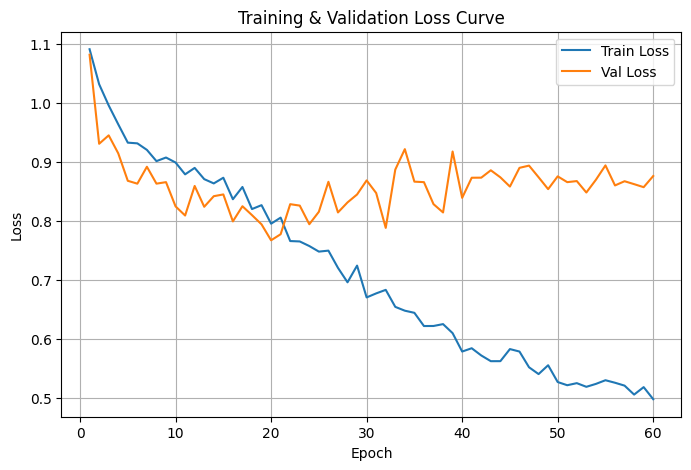

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv("../models/3d_resnet/training_log.csv")

plt.figure(figsize=(8,5))
plt.plot(log["epoch"], log["train_loss"], label="Train Loss")
plt.plot(log["epoch"], log["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve_resnet.png", dpi=300, bbox_inches='tight')
plt.show()


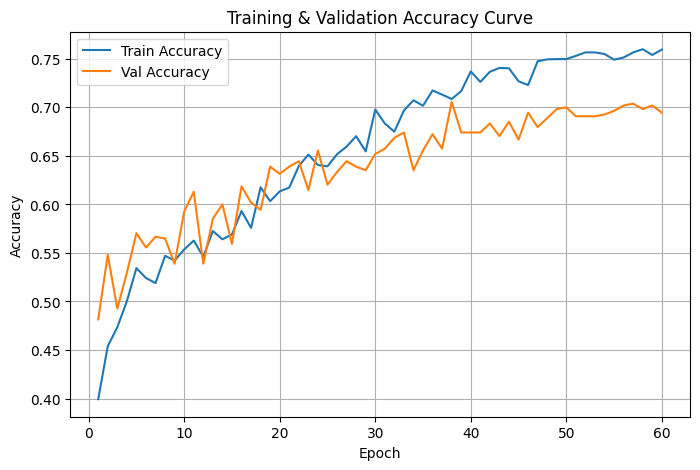

In [48]:
plt.figure(figsize=(8,5))
plt.plot(log["epoch"], log["train_acc"], label="Train Accuracy")
plt.plot(log["epoch"], log["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Curve")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_curve.png", dpi=300, bbox_inches='tight')
plt.show()


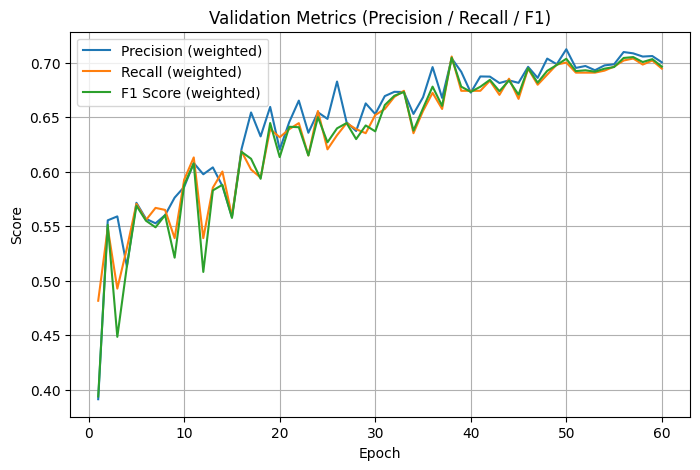

In [49]:
plt.figure(figsize=(8,5))
plt.plot(log["epoch"], log["precision"], label="Precision (weighted)")
plt.plot(log["epoch"], log["recall"], label="Recall (weighted)")
plt.plot(log["epoch"], log["f1"], label="F1 Score (weighted)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics (Precision / Recall / F1)")
plt.legend()
plt.grid(True)
plt.savefig("metrics_curve.png", dpi=300, bbox_inches='tight')
plt.show()


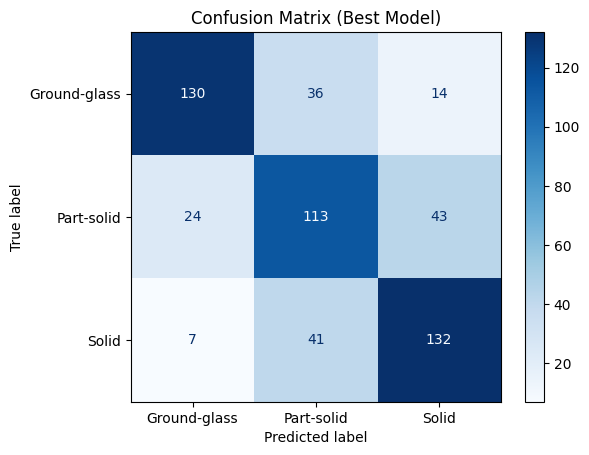

              precision    recall  f1-score   support

Ground-glass       0.81      0.72      0.76       180
  Part-solid       0.59      0.63      0.61       180
       Solid       0.70      0.73      0.72       180

    accuracy                           0.69       540
   macro avg       0.70      0.69      0.70       540
weighted avg       0.70      0.69      0.70       540



In [61]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# Load metadata
# -----------------------
df = pd.read_csv("../metadata/augmented_classification_metadata.csv")
df['image'] = df['image'].apply(fix_path)
df['mask'] = df['mask'].apply(fix_path)
# Load your split function if needed
def stratified_split(df, val_frac=0.15, seed=42):
    import numpy as np
    np.random.seed(seed)
    train_idxs, val_idxs = [], []
    
    for lbl in sorted(df["label_3class"].unique()):
        idxs = df[df["label_3class"] == lbl].index.values
        np.random.shuffle(idxs)
        n_val = int(len(idxs) * val_frac)
        val_idxs.extend(idxs[:n_val])
        train_idxs.extend(idxs[n_val:])
    return df.loc[train_idxs], df.loc[val_idxs]

_, val_df = stratified_split(df)

# -----------------------
# Dataset + Dataloader
# -----------------------
val_ds = NiiDataset(val_df, augment=False)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

# -----------------------
# Load best model
# -----------------------
checkpoint = torch.load("../models/3d_resnet/best_resnet.pth", map_location="cuda")
model = build_model(num_classes=3)
model.load_state_dict(checkpoint["model_state"])
model = model.to("cuda")
model.eval()

# -----------------------
# Run validation again
# -----------------------
val_targets = []
val_preds = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to("cuda")
        y = y.to("cuda")
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        val_preds.extend(preds)
        val_targets.extend(y.cpu().numpy())

# -----------------------
# Confusion Matrix
# -----------------------
cm = confusion_matrix(val_targets, val_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Ground-glass", "Part-solid", "Solid"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Best Model)")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print(classification_report(val_targets, val_preds, target_names=["Ground-glass", "Part-solid", "Solid"]))



In [52]:
def get_accuracy_score(model_name,y_test, y_predicted):
  accuracy = accuracy_score(y_test, y_predicted)
  print(f"{model_name} Model Accuracy: {round(accuracy*100,2)} %")
  return round(accuracy*100,2)

def generate_classification_report(y_test, y_predicted):
  report = classification_report(y_test, y_predicted, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  return report_df

In [53]:
get_accuracy_score('ResNet18',val_targets,val_preds)

ResNet18 Model Accuracy: 69.44 %


69.44

In [54]:
generate_classification_report(val_targets,val_preds)

,precision,recall,f1-score,support
0,0.807453,0.722222,0.762463,180.000000
1,0.594737,0.627778,0.610811,180.000000
2,0.698413,0.733333,0.715447,180.000000
accuracy,0.694444,0.694444,0.694444,0.694444
macro avg,0.700201,0.694444,0.696240,540.000000
weighted avg,0.700201,0.694444,0.696240,540.000000


In [55]:
df

,uid,image,mask,texture_class,label_3class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,solid,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,ground-glass,2
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,solid,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,solid,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279...,../dataset/masks/1_3_6_1_4_1_14519_5_2_1_6279_...,solid,0
...,...,...,...,...,...
3595,1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988...,../dataset/../dataset/augmented/solid/1.3.6.1....,../dataset/../dataset/augmented/solid/1.3.6.1....,solid,0
3596,1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988...,../dataset/../dataset/augmented/solid/1.3.6.1....,../dataset/../dataset/augmented/solid/1.3.6.1....,solid,0
3597,1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988...,../dataset/../dataset/augmented/solid/1.3.6.1....,../dataset/../dataset/augmented/solid/1.3.6.1....,solid,0
3598,1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988...,../dataset/../dataset/augmented/solid/1.3.6.1....,../dataset/../dataset/augmented/solid/1.3.6.1....,solid,0


# Inference

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import nibabel as nib
import scipy.ndimage as ndi

from torchvision.models.video import r3d_18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_PATH = "../models/3d_resnet/last_model.pth"  # update path
INPUT_SHAPE = (64, 64, 64)                    # expected model input (D,H,W)

LABELS = {
    2: "ground-glass",
    1: "part-solid",
    0: "solid"
}

def build_model(num_classes=3, pretrained=False):
    model = r3d_18(pretrained=pretrained)

    # modify conv1 to accept 1 channel
    old_conv = model.stem[0]
    new_conv = nn.Conv3d(
        1, old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False
    )

    # if pretrained weights, average channels
    if pretrained:
        new_conv.weight.data = old_conv.weight.data.mean(dim=1, keepdim=True)

    model.stem[0] = new_conv

    # replace classification head
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


def load_classifier():
    model = build_model(pretrained=False).to(DEVICE)
    ckpt = torch.load(MODEL_PATH, map_location=DEVICE)

    # flexible checkpoint loading
    if "model_state" in ckpt:
        model.load_state_dict(ckpt["model_state"])
    elif "model_state_dict" in ckpt:
        model.load_state_dict(ckpt["model_state_dict"])
    else:
        model.load_state_dict(ckpt)

    model.eval()
    return model


def load_nii_patch(path):
    nii = nib.load(path)
    img = nii.get_fdata().astype(np.float32)

    # Resize only if needed
    if img.shape != INPUT_SHAPE:
        zoom = [INPUT_SHAPE[i] / img.shape[i] for i in range(3)]
        img = ndi.zoom(img, zoom, order=1)

    # Normalization (same as training: zero-mean, unit-std)
    img = (img - img.mean()) / (img.std() + 1e-8)

    # Convert to tensor shape (B, C=1, D, H, W)
    t = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float().to(DEVICE)
    return img, t


def classify_nodule(patch_path):
    model = load_classifier()

    img_np, img_tensor = load_nii_patch(patch_path)

    with torch.no_grad():
        logits = model(img_tensor)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()

    pred_idx = int(np.argmax(probs))
    pred_label = LABELS[pred_idx]
    pred_prob = float(probs[pred_idx])

    # prepare structured output
    return {
        "predicted_class": pred_label,
        "probability": pred_prob,
        "all_probabilities": {LABELS[i]: float(probs[i]) for i in range(3)}
    }

In [57]:
patch_path = "../dataset/images/1_3_6_1_4_1_14519_5_2_1_6279_6001_866845763956586959109892274084_1122.nii.gz"   # update this

result = classify_nodule(patch_path)

print("\n===== 3D RESNET INFERENCE RESULT =====")
print("Predicted Class:", result["predicted_class"])
print("Confidence     :", f"{result['probability']:.4f}")

print("\nFull Probabilities:")
for cls, p in result["all_probabilities"].items():
    print(f"  {cls:12s} → {p:.4f}")


===== 3D RESNET INFERENCE RESULT =====
Predicted Class: solid
Confidence     : 0.9871

Full Probabilities:
  solid        → 0.9871
  part-solid   → 0.0068
  ground-glass → 0.0061


In [58]:
def show_nii_image(nii_path):
    """
    Displays axial, coronal, and sagittal slices of a 3D NIfTI (.nii.gz) image.
    """

    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt

    # Load NIfTI
    img = nib.load(nii_path).get_fdata().astype(np.float32)

    # Central slices
    D, H, W = img.shape
    axial = img[D // 2]             # z-axis
    coronal = img[:, H // 2, :]     # y-axis
    sagittal = img[:, :, W // 2]    # x-axis

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    axes[0].imshow(axial, cmap="gray")
    axes[0].set_title("Axial (Z)")
    axes[0].axis("off")

    axes[1].imshow(coronal, cmap="gray")
    axes[1].set_title("Coronal (Y)")
    axes[1].axis("off")

    axes[2].imshow(sagittal, cmap="gray")
    axes[2].set_title("Sagittal (X)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


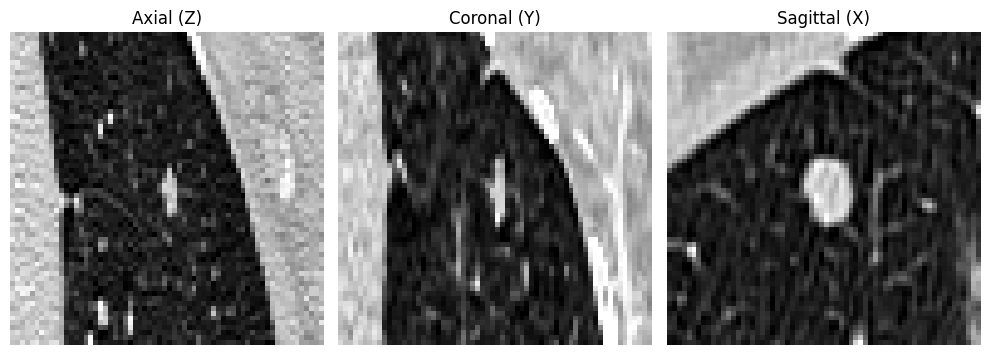

In [59]:
show_nii_image(patch_path)